# Import needed libraries

In [1]:
import os
import cv2
import time
import random
import numpy as np
from glob import glob
from tqdm import tqdm
from operator import add
import gc
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score, roc_auc_score
import albumentations as A
from torchsummary import summary
import tifffile
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

/usr/local/lib/python3.10/dist-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


# Define Dataset and preprocessing functions

In [2]:
## Define preprocessing function for images and masks
def preprocess_image(data_folder):
    image = tifffile.imread(data_folder)

    #add a channel dimension for grayscale image
    if image.ndim == 2:
        image = image[..., np.newaxis]

    # Normalize the pixel values
    mean = np.mean(image)
    std = np.std(image)
    image = (image - mean) / std

    # Resize image to have 1x256x256
    image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # channel-first format
    transform = transforms.Compose([
        transforms.Resize((256, 256))
    ])
    image_tensor = transform(image_tensor.unsqueeze(0)).squeeze(0)

    return image_tensor

def preprocess_mask(path):
    mask = tifffile.imread(path)

    #add a channel dimension for grayscale image
    if mask.ndim == 2:  
        mask = mask[..., np.newaxis]  

    # Normalize the pixel values
    mask_tensor = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1) / 255.0  # Change to channel-first format

    transform = transforms.Compose([
        transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)
    ])
    mask_tensor = transform(mask_tensor.unsqueeze(0)).squeeze(0)

    return mask_tensor


## define augmentation for training data
def augment_image(image, mask):
    
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.permute(1, 2, 0).numpy()

    transform = A.Compose([
        A.Resize(256,256, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.RandomCrop(height=256, width=256, always_apply=True),
        # A.RandomBrightness(p=1),
        A.OneOf(
            [
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
    
    ])
    augmented = transform(image = image_np,mask = mask_np)
    augmented_image , augmented_mask = augmented['image'],augmented['mask']
    
    augmented_image = torch.tensor(augmented_image, dtype=torch.float32).permute(2, 0, 1)
    augmented_mask  = torch.tensor(augmented_mask,dtype=torch.float32).permute(2, 0, 1)
    
    return augmented_image,augmented_mask

## Defin custom dataset
class KidneyDataset(Dataset):
    def __init__(self,image_files, mask_files, input_size=(256, 256), augmentation_transforms=None):
        self.image_files=image_files
        self.mask_files=mask_files
        self.input_size=input_size
        self.augmentation_transforms=augmentation_transforms
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self,idx):
        image_path=self.image_files[idx]
        mask_path=self.mask_files[idx]
        
        image = preprocess_image(image_path)
        mask = preprocess_mask(mask_path)
        if self.augmentation_transforms:
            image,mask=self.augmentation_transforms(image,mask)
        return image,mask


# Create the different Deep Learning model
## Unet

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            # nn.Dropout(dropout),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class DecoderBlockUnet(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_channels,out_channels)

    def forward(self,x,skip):
        x = self.up(x)
        return self.double_conv(torch.cat([x,skip],1))

class EncoderBlockUnet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.double_conv(x)
        p = self.pool(down)

        return down, p

class UNet(nn.Module):
    def __init__(self,in_channels=1,out_channels=1):
        super(UNet,self).__init__()
        self.enc1 = EncoderBlockUnet(in_channels,64)
        self.enc2 = EncoderBlockUnet(64,128)
        self.enc3 = EncoderBlockUnet(128,256)
        self.enc4 = EncoderBlockUnet(256,512)
        self.bottleneck = DoubleConv(512,1024)

        self.dec1 = DecoderBlockUnet(1024,512)
        self.dec2 = DecoderBlockUnet(512,256)
        self.dec3 = DecoderBlockUnet(256,128)
        self.dec4 = DecoderBlockUnet(128,64)

        self.final_conv = nn.Conv2d(64,out_channels, kernel_size=1)

    def forward(self, x):
        down1, x1 = self.enc1(x)
        down2, x2 = self.enc2(x1)
        down3, x3 = self.enc3(x2)
        down4, x4 = self.enc4(x3)

        bottleneck = self.bottleneck(x4)
        # print(f"Bottleneck shape: {bottleneck.shape} enc4 shape: {x4.shape}")
        dec1 = self.dec1(bottleneck,down4)
        dec2 = self.dec2(dec1, down3)
        dec3 = self.dec3(dec2, down2)
        dec4 = self.dec4(dec3, down1)

        # return torch.sigmoid(self.final_conv(dec4))
        return self.final_conv(dec4)


## Residual Unet

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, padding):
        super(ResidualBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(
                in_channels, out_channels, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.conv_block(x) + self.conv_skip(x)


class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)

class ResidualUNet(nn.Module):
    def __init__(self, in_channels, out_channels,filters=[64, 128, 256, 512]):
        super(ResidualUNet, self).__init__()

        self.input_conv = nn.Sequential(
            nn.Conv2d(in_channels, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Conv2d(in_channels, filters[0], kernel_size=3, padding=1)
        self.enc2 = ResidualBlock(filters[0], filters[1], 2, 1)
        self.enc3 = ResidualBlock(filters[1], filters[2], 2, 1)

        self.bridge = ResidualBlock(filters[2], filters[3], 2, 1)

        self.upsample1 = Upsample(filters[3], filters[3], 2, 2)
        self.dec1 = ResidualBlock(filters[3] + filters[2], filters[2], 1, 1)
        self.upsample2 = Upsample(filters[2], filters[2], 2, 2)
        self.dec2 = ResidualBlock(filters[2] + filters[1], filters[1], 1, 1)
        self.upsample3 = Upsample(filters[1], filters[1], 2, 2)
        self.dec3 = ResidualBlock(filters[1] + filters[0], filters[0], 1, 1)

        self.output_layer = nn.Sequential(
            nn.Conv2d(filters[0], out_channels, 1, 1)
            # nn.Sigmoid(),
        )

    def forward(self, x):
        # Encoders
        down1 = self.input_conv(x) + self.input_skip(x)
        down2 = self.enc2(down1)
        down3 = self.enc3(down2)

        # Bridge
        b = self.bridge(down3)

        # Decoders
        up1 = self.upsample1(b)
        up1 = torch.cat([up1, down3], dim=1)
        up1 = self.dec1(up1)

        up2 = self.upsample2(up1)
        up2 = torch.cat([up2, down2], dim=1)
        up2 = self.dec2(up2)

        up3 = self.upsample3(up2)
        up3 = torch.cat([up3, down1], dim=1)
        up3 = self.dec3(up3)

        output = self.output_layer(up3)

        return output

## SegNet

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3,padding=1):
        super(ConvBlock, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        return self.layer(x)

class EncoderBlockSegnet(nn.Module):
    def __init__(self, in_channels, out_channels, depth=2, kernel_size=3, padding=1):
        super(EncoderBlockSegnet, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(ConvBlock(in_channels if i == 0 else out_channels, out_channels, kernel_size, padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, indices = self.pool(x)
        return x, indices

class DecoderBlockSegnet(nn.Module):
    def __init__(self, in_channels, out_channels, depth=2, kernel_size=3, padding=1, classification=False) -> None:
        super(DecoderBlockSegnet, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == depth - 1 and classification:
                self.layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
            elif i == depth - 1:
                self.layers.append(ConvBlock(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
            else:
                self.layers.append(ConvBlock(in_channels, in_channels, kernel_size=kernel_size, padding=padding))

    def forward(self, x, ind):
        x = self.unpool(x, ind)
        for layer in self.layers:
            x = layer(x)
        return x

class SegNet(nn.Module): 
    def __init__(self, in_channels=3, out_channels=1, features=64) -> None:
        super(SegNet, self).__init__()

        # Encoder
        self.enc0 = EncoderBlockSegnet(in_channels, features, depth=2)
        self.enc1 = EncoderBlockSegnet(features, features * 2, depth=2)
        self.enc2 = EncoderBlockSegnet(features * 2, features * 4, depth=3)
        self.enc3 = EncoderBlockSegnet(features * 4, features * 8, depth=3)
        self.enc4 = EncoderBlockSegnet(features * 8, features * 8, depth=3)

        # Decoder
        self.dec0 = DecoderBlockSegnet(features * 8, features * 8, depth=3) 
        self.dec1 = DecoderBlockSegnet(features * 8, features * 4, depth=3)
        self.dec2 = DecoderBlockSegnet(features * 4, features * 2, depth=3)
        self.dec3 = DecoderBlockSegnet(features * 2, features, depth=2)
        self.dec4 = DecoderBlockSegnet(features, out_channels, depth=2, classification=True) # No activation

    def forward(self, x):
        # encoder
        e0, ind0 = self.enc0(x) 
        e1, ind1 = self.enc1(e0) 
        e2, ind2 = self.enc2(e1) 
        e3, ind3 = self.enc3(e2)
        e4, ind4 = self.enc4(e3)

        # decoder
        d0 = self.dec0(e4, ind4)
        d1 = self.dec1(d0, ind3)
        d2 = self.dec2(d1, ind2)
        d3 = self.dec3(d2, ind1)

        # classification layer
        output = self.dec4(d3, ind0)  
        # return F.sigmoid(output)
        return output


## U-SegNet (1-skip, 2-skip, 3-skip)

In [6]:
class EncoderBlockUsegnet(nn.Module):
    def __init__(self, in_channels, out_channels, depth=2, kernel_size=3, padding=1):
        super(EncoderBlockUsegnet, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(ConvBlock(in_channels if i == 0 else out_channels, out_channels, kernel_size, padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, down):
        for layer in self.layers:
            down = layer(down)
        x, indices = self.pool(down)
        return x, down, indices #down for skip connection


class DecoderBlockSkip(nn.Module):
    def __init__(self, in_channels, out_channels, depth=2, kernel_size=3, padding=1, classification=False) -> None:
        super(DecoderBlockSkip, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == 0:  # Adjust the first layer for concatenated channels
                self.layers.append(ConvBlock(in_channels * 2, in_channels, kernel_size=kernel_size, padding=padding))
            elif i == depth - 1 and classification:
                self.layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
            elif i == depth - 1:
                self.layers.append(ConvBlock(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
            else:
                self.layers.append(ConvBlock(in_channels, in_channels, kernel_size=kernel_size, padding=padding))

    def forward(self, x, ind, skip):
        x = self.unpool(x, ind)
        # print(f"decoder unpool: {x.shape}, skip :{skip.shape}")
        x = torch.cat([x, skip], 1)
        for layer in self.layers:
            x = layer(x)
        return x


class SegUNet_3skip(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SegUNet_3skip, self).__init__()
        self.enc1 = EncoderBlockUsegnet(in_channels, 64, depth=2)
        self.enc2 = EncoderBlockUsegnet(64, 128, depth=2)
        self.enc3 = EncoderBlockUsegnet(128, 256, depth=3)
        # self.enc4 = EncoderBlock(256,256, depth=3)

        # self.dec2 = DecoderBlock(256,256,depth=3)
        self.dec3 = DecoderBlockSkip(256,128, depth=3)
        self.dec4 = DecoderBlockSkip(128,64,depth=2)
        self.dec5 = DecoderBlockSkip(64,out_channels, depth=2, classification=True)  # Classification=True ensures correct final output.

        # self_final = nn.Conv2d(64,out_channels, kernel_size=1)    
    def forward(self, x):
        # Encoder
        x1, down1, ind1 = self.enc1(x)
        # print(f"x1: {x1.shape}, down1: {down1.shape}, ind1: {ind1.shape}")
        x2, down2, ind2 = self.enc2(x1)
        # print(f"x2: {x2.shape}, down2: {down2.shape}, ind2: {ind2.shape}")
        x3, down3, ind3 = self.enc3(x2)
        # print(f"x3: {x3.shape}, down3: {down3.shape}, ind3: {ind3.shape}")
        # x4, down4, ind4 = self.enc4(x3)
        # print(f"x4: {x4.shape}, down4: {down4.shape}, ind4: {ind4.shape}")

        # Decoder
        # dec2 = self.dec2(x4,ind4,down4)
        dec3 = self.dec3(x3, ind3, down3)
        dec4 = self.dec4(dec3, ind2, down2)
        dec5 = self.dec5(dec4, ind1, down1)

        return dec5

class SegUNet_2skip(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SegUNet_2skip, self).__init__()
        self.enc1 = EncoderBlockUsegnet(in_channels, 64, depth=2)
        self.enc2 = EncoderBlockUsegnet(64, 128, depth=2)
        self.enc3 = EncoderBlockUsegnet(128, 256, depth=3)
        # self.enc4 = EncoderBlock(256,256, depth=3)

        # self.dec2 = DecoderBlock(256,256,depth=3)
        self.dec3 = DecoderBlockSegnet(256,128, depth=3)
        self.dec4 = DecoderBlockSkip(128,64,depth=2)
        self.dec5 = DecoderBlockSkip(64,out_channels, depth=2, classification=True)  # Classification=True ensures correct final output.

        # self_final = nn.Conv2d(64,out_channels, kernel_size=1)    
    def forward(self, x):
        # Encoder
        x1, down1, ind1 = self.enc1(x)
        # print(f"x1: {x1.shape}, down1: {down1.shape}, ind1: {ind1.shape}")
        x2, down2, ind2 = self.enc2(x1)
        # print(f"x2: {x2.shape}, down2: {down2.shape}, ind2: {ind2.shape}")
        x3, down3, ind3 = self.enc3(x2)
        # print(f"x3: {x3.shape}, down3: {down3.shape}, ind3: {ind3.shape}")
        # x4, down4, ind4 = self.enc4(x3)
        # print(f"x4: {x4.shape}, down4: {down4.shape}, ind4: {ind4.shape}")

        # Decoder
        # dec2 = self.dec2(x4,ind4,down4)
        dec3 = self.dec3(x3, ind3) #, down3)
        dec4 = self.dec4(dec3, ind2, down2)
        dec5 = self.dec5(dec4, ind1, down1)

        return dec5


class SegUNet_1skip(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SegUNet_1skip, self).__init__()
        self.enc1 = EncoderBlockUsegnet(in_channels, 64, depth=2)
        self.enc2 = EncoderBlockUsegnet(64, 128, depth=2)
        self.enc3 = EncoderBlockUsegnet(128, 256, depth=3)
        # self.enc4 = EncoderBlock(256,256, depth=3)

        # self.dec2 = DecoderBlock(256,256,depth=3)
        self.dec3 = DecoderBlockSegnet(256,128, depth=3)
        self.dec4 = DecoderBlockSegnet(128,64,depth=2)
        self.dec5 = DecoderBlockSkip(64,out_channels, depth=2, classification=True)  # Classification=True ensures correct final output.

        # self_final = nn.Conv2d(64,out_channels, kernel_size=1)    
    def forward(self, x):
        # Encoder
        x1, down1, ind1 = self.enc1(x)
        # print(f"x1: {x1.shape}, down1: {down1.shape}, ind1: {ind1.shape}")
        x2, down2, ind2 = self.enc2(x1)
        # print(f"x2: {x2.shape}, down2: {down2.shape}, ind2: {ind2.shape}")
        x3, down3, ind3 = self.enc3(x2)
        # print(f"x3: {x3.shape}, down3: {down3.shape}, ind3: {ind3.shape}")
        # x4, down4, ind4 = self.enc4(x3)
        # print(f"x4: {x4.shape}, down4: {down4.shape}, ind4: {ind4.shape}")

        # Decoder
        # dec2 = self.dec2(x4,ind4,down4)
        dec3 = self.dec3(x3, ind3) #, down3)
        dec4 = self.dec4(dec3, ind2) #, down2)
        dec5 = self.dec5(dec4, ind1, down1)

        return dec5

## Res-USegNet

In [7]:
class EncoderBlockSegRes(nn.Module):
    def __init__(self, in_channels, out_channels, depth=2, stride=1, padding=1):
        super(EncoderBlockSegRes, self).__init__()
        self.residual_layers = nn.ModuleList()
        for i in range(depth):
            self.residual_layers.append(ResidualBlock(in_channels if i == 0 else out_channels, out_channels, stride, padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.residual_layers:
            x = layer(x)
        down, indices = self.pool(x)
        return down, x, indices  # Down for next layer, x for skip connection

class ResidualUSegNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualUSegNet, self).__init__()
        # Encoder
        self.enc1 = EncoderBlockSegRes(in_channels, 64, depth=2)
        self.enc2 = EncoderBlockSegRes(64, 128, depth=2)
        self.enc3 = EncoderBlockSegRes(128, 256, depth=3)


        # Decoder
        self.dec3 = DecoderBlockSkip(256, 128, depth=3)
        self.dec2 = DecoderBlockSkip(128, 64, depth=2)
        self.dec1 = DecoderBlockSkip(64, out_channels, depth=2)


    def forward(self, x):
        # Encoder
        x1, skip1, ind1 = self.enc1(x)
        x2, skip2, ind2 = self.enc2(x1)
        x3, skip3, ind3 = self.enc3(x2)

        # Decoder
        d3 = self.dec3(x3, ind3, skip3)
        d2 = self.dec2(d3, ind2, skip2)
        d1 = self.dec1(d2, ind1, skip1)
        return d1


## Utils functions

### Losses classes

In [8]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-2):

        # comment out if the model contains a sigmoid  layer
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # for binary classification here
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice  # 1-score to have loss


class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()

    def forward(self, preds, targets, smooth=1e-2):

        # comment out if the model contains a sigmoid layer
        preds = torch.sigmoid(preds)

        preds = preds.view(-1)
        targets = targets.view(-1)

        # compute dice_loss
        intersection = (preds * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth) / (preds.sum() + targets.sum() + smooth)

        # compute BCE loss
        BCE = F.binary_cross_entropy(preds, targets, reduction='mean')

        return BCE + dice_loss

## Score and metrics

In [9]:
def multiclass_dice_score(pred, target, num_classes, smooth=1e-6):
    pred = pred.argmax(dim=1)  # Convert logits to class indices
    dice_scores = []
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        dice_scores.append(dice_score(pred_cls, target_cls, smooth))
    return sum(dice_scores) / num_classes

def dice_score(pred, target, smooth=1e-6):
    # Compute intersection and union
    intersection = (pred * target).sum()
    total = pred.sum() + target.sum()
    dice = (2. * intersection + smooth) / (total + smooth)
    return dice

def iou_score(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    total = pred.sum() + target.sum()
    iou = (intersection + smooth) / (total - intersection + smooth)
    return iou

def calculate_metrics(y_true, y_pred, smooth=1e-6):
    # Binarize ground truth and predictions
    y_true_bin = (y_true > 0.5).float().view(-1).cpu().numpy().astype(np.uint8)
    y_pred_bin = (torch.sigmoid(y_pred) > 0.5).float().view(-1).cpu().numpy().astype(np.uint8)

    # Calculate metrics
    score_jaccard = jaccard_score(y_true_bin, y_pred_bin, average='binary')
    score_f1 = f1_score(y_true_bin, y_pred_bin, average='binary')
    score_recall = recall_score(y_true_bin, y_pred_bin, average='binary')
    score_precision = precision_score(y_true_bin, y_pred_bin, average='binary')
    score_acc = accuracy_score(y_true_bin, y_pred_bin)
    score_dice = dice_score(y_pred_bin, y_true_bin, smooth)
    score_iou = iou_score(y_pred_bin, y_true_bin, smooth)
    return {'jaccard': score_jaccard, 'f1':score_f1, 'recall':score_recall, 'precision':score_precision, 'acc':score_acc, 'dice': score_dice, 'iou':score_iou} #, 'roc_auc':roc_auc}



### Visualization and Evaluation

In [10]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def visualize_segmentation(model, dataloader, device='cuda', num_samples=5):
    # Set the model to evaluation mode
    model.eval()
    samples_shown = 0
    plt.figure(figsize=(15, num_samples * 5))
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if samples_shown >= num_samples:
                break
            images = images.to(device)
            masks = masks.to(device)

            predictions = model(images)

            #multiclass predictions
            if predictions.shape[1] > 1:
                predictions = torch.argmax(predictions, dim=1, keepdim=True)
            # binary predictions
            else:  # Binary
                predictions = (torch.sigmoid(predictions) > 0.5).float()

            # visualize num_samples image to compare ground truth and predictions
            for j in range(images.size(0)):
                if samples_shown >= num_samples:
                    break
                
                img = images[j].cpu().permute(1, 2, 0).numpy()  # Convert to (H, W, 3)
                mask = masks[j].cpu().squeeze(0).numpy()  # Ground truth mask
                pred_mask = predictions[j].cpu().squeeze(0).numpy()  # Predicted mask

                plt.subplot(num_samples, 3, samples_shown * 3 + 1)
                plt.imshow(img)
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(num_samples, 3, samples_shown * 3 + 2)
                plt.imshow(mask, cmap='gray')
                plt.title("Ground Truth Mask")
                plt.axis("off")

                plt.subplot(num_samples, 3, samples_shown * 3 + 3)
                plt.imshow(pred_mask, cmap='gray')
                plt.title("Predicted Mask")
                plt.axis("off")

                samples_shown += 1

    plt.tight_layout()
    plt.show()

def plot_metrics(metrics_file, output_dir="plots", model_name="model"):
    # Load metrics from CSV
    df = pd.read_csv(metrics_file)
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Plot each metric
    metrics = [col for col in df.columns if col not in ['epoch', 'train_loss', 'val_loss']]
    for metric in metrics:
        plt.figure(figsize=(8, 6))
        
        if f"train_{metric}" in df.columns and f"val_{metric}" in df.columns:
            plt.plot(df['epoch'], df[f'train_{metric}'], label=f'Train {metric}', marker='o')
            plt.plot(df['epoch'], df[f'val_{metric}'], label=f'Validation {metric}', marker='o')
        elif metric in df.columns:  # Single metric column
            plt.plot(df['epoch'], df[metric], label=f'{metric}', marker='o')
        
        plt.xlabel("Epoch")
        plt.ylabel(metric.capitalize())
        plt.title(f"{metric.capitalize()} over Epochs ({model_name})")
        plt.legend()
        plt.grid()
        
        # Save the plot
        plot_path = os.path.join(output_dir, f"{model_name}_{metric}.png")
        plt.savefig(plot_path)
        plt.close()
        print(f"Saved plot: {plot_path}")

def evaluate_model(model, dataloader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            # Get model predictions
            predictions = model(images)

            # For multiclass classification (more than 1 class)
            if predictions.shape[1] > 1:
                predictions = torch.argmax(predictions, dim=1)
            else:  # Binary classification (2 classes)
                predictions = (torch.sigmoid(predictions) > 0.5).float()

            # Flatten predictions and labels
            all_preds.append(predictions.view(-1).cpu())
            all_labels.append(masks.view(-1).cpu())  

    # Concatenate all predictions and labels into 1D tensors
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Ensure both are of integer type for evaluation metrics
    all_preds = all_preds.astype(int)
    all_labels = all_labels.astype(int)

    # Compute metrics
    f1 = f1_score(all_labels, all_preds, average='macro')  # 'macro' for multi-class or binary
    acc = accuracy_score(all_labels, all_preds)
    dice = dice_score(all_preds, all_labels)  

    return {"Dice": dice, "F1": f1, "Accuracy": acc}

def build_metrics_table_and_visualize(models, dataloader, device='cuda', num_samples=3):
    metrics = []
    for model_name, model in models.items():
        # Load the model
        model.load_state_dict(torch.load(f"/kaggle/working/{model_name}_checkpoint.pth",weights_only=True))
        model.to(device).eval()

        # Evaluate the model
        model_metrics = evaluate_model(model, dataloader, device)
        metrics.append({"Model": model_name, **model_metrics})

    # Create and display metrics table
    metrics_df = pd.DataFrame(metrics)
    metrics_df['Model']=metrics_df['Model'].map({
        'unet':'UNet','segnet':'SegNet','residual_unet':'Residual UNet','usegnet_3skip':'U-SegNet 3 skip','usegnet_2skip':'U-SegNet 2 skip',
    'usegnet_1skip':'U-SegNet 1 skip','resusegnet':'Residual U-SegNet'})
    metrics_df.to_csv('/kaggle/working/best_metrics_comparison.csv')
    print(metrics_df)

def visualize_segmentation_on_two_rows(models, dataloader, device='cuda', num_samples=1):

    num_models = len(models)
    model_names = list(models.keys())
    
    samples_shown = 0

    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if samples_shown >= num_samples:
                break
            images = images.to(device)
            masks = masks.to(device)

            # visualize num_samples image to compare ground truth and predictions
            for j in range(images.size(0)):
                if samples_shown >= num_samples:
                    break

                fig, axes = plt.subplots(2, 3, figsize=(15, 10))
                fig.suptitle(f"Sample {samples_shown + 1}", fontsize=16)

                img = images[j].cpu().permute(1, 2, 0).numpy()  # Convert to (H, W, 3)
                axes[0, 0].imshow(img, cmap='gray')
                axes[0, 0].set_title("Input Image")
                axes[0, 0].axis("off")

                # Ground Truth Mask
                mask = masks[j].cpu().squeeze(0).numpy()  # Ground truth mask
                axes[1, 0].imshow(img, cmap='gray')
                axes[1, 0].contour(mask, colors='blue')
                axes[1, 0].set_title("Ground Truth")
                axes[1, 0].axis("off")

                # Predictions for each model
                for idx, (model_name, model) in enumerate(models.items()):
                    
                    # Load the model's weights (assumed the models have been saved)
                    model.load_state_dict(torch.load(f"/kaggle/working/{model_name}_checkpoint.pth",weights_only=True))
                    model.to(device).eval()
                    
                    predictions = model(images)
                    if predictions.shape[1] > 1:  # Multiclass
                        predictions = torch.argmax(predictions, dim=1, keepdim=True)
                    else:  # Binary
                        predictions = (torch.sigmoid(predictions) > 0.5).float()

                    pred_mask = predictions[j].cpu().squeeze(0).numpy()  # Predicted mask
                    
                    # Predicted masks
                    axes[idx%2, idx//2 + 1].imshow(img, cmap='gray')
                    axes[idx%2, idx//2 + 1].contour(pred_mask, colors='r')
                    axes[idx%2, idx//2 + 1].set_title(f"{model_name} (Pred)")
                    axes[idx%2, idx//2 + 1].axis("off")

                plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust to fit suptitle
                plot_path = f"/kaggle/working/predictions_{samples_shown}.png"
                plt.savefig(plot_path)
                print(f"Saved the plot as: {plot_path}")
                plt.show()
                plt.close()
                samples_shown += 1

## train function

In [11]:
def train_model(model, train_loader, val_loader,device, model_name, criterion=None, optimizer=None, lr=1e-4, num_epochs=50, patience=10):

    checkpoint_path = f"/kaggle/working/{model_name}_checkpoint.pth"
    model = model.to(device)
    
    # Set Optimizer and Loss
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    if criterion is None:
        criterion = DiceBCELoss()
    best_dice = -1.*float("inf")
    early_stopping_counter = 0
    
    train_losses = []
    val_losses = []

    train_metrics = {
        'jaccard':[],
        'f1':[],
        'recall':[],
        'precision':[],
        'acc':[],
        'dice':[],
        'iou':[]
    }
    val_metrics = {
        'jaccard':[],
        'f1':[],
        'recall':[],
        'precision':[],
        'acc':[],
        'dice': [],
        'iou':[]
    }
    
    for epoch in range(num_epochs):
        start_time = time.time()
        valid_loss = 0.0
        train_loss = 0.0
            
        model.train()
        train_epoch_metrics = {key: 0.0 for key in train_metrics}
        
        for x, y in train_loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
    
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            for key, value in calculate_metrics(y, y_pred).items():
                train_epoch_metrics[key]+=value
    
        train_loss = train_loss/len(train_loader)
        train_losses.append(train_loss)
        for key, value in train_epoch_metrics.items():
            train_metrics[key].append(value/len(train_loader))
        
        model.eval()
        val_epoch_metrics = {key: 0.0 for key in val_metrics}
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device, dtype=torch.float32)
                y = y.to(device, dtype=torch.float32)
    
                y_pred = model(x)
                loss = criterion(y_pred, y)
                valid_loss += loss.item()
                for key, value in calculate_metrics(y, y_pred).items():
                    val_epoch_metrics[key]+=value
    
            valid_loss = valid_loss / len(val_loader)
            val_losses.append(valid_loss)
            for key, value in val_epoch_metrics.items():
                val_metrics[key].append(value/len(val_loader))
        
        # Saving the model
        if val_metrics['dice'][-1] > best_dice:
            print(f"Validation Dice score improved from {best_dice:2.4f} to {val_metrics['dice'][-1]:2.4f}. Saving checkpoint: {checkpoint_path}")
    
            best_dice = val_metrics['dice'][-1]
            torch.save(model.state_dict(), checkpoint_path)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered.")
                break

        scheduler.step(valid_loss)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
        print(f"Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
        print(f"\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}")
        print(f"\tVal Acc: {val_metrics['acc'][-1]:.3f} | Val Dice: {val_metrics['dice'][-1]:.3f} | Val IOU: {val_metrics['iou'][-1]:.3f}")

        # Save metrics to CSV
    metrics_df = pd.DataFrame({
        'epoch': list(range(1, len(train_losses) + 1)),
        'train_loss': train_losses,
        'val_loss': val_losses,
        **{f'train_{key}': train_metrics[key] for key in train_metrics},
        **{f'val_{key}': val_metrics[key] for key in val_metrics},
    })
    metrics_df.to_csv(f"{model_name}_metrics.csv", index=False)
        
    return model, train_losses, val_losses, train_metrics, val_metrics


    

# Data Preparation


### Get data paths

In [12]:
#  Get data paths
base_path = "/kaggle/input/blood-vessel-segmentation/train"
dataset = "kidney_1_dense"

images_path = os.path.join(base_path,dataset,"images")
label_path = os.path.join(base_path,dataset,"labels")

image_files= sorted([os.path.join(images_path,f) for f in os.listdir(images_path) if f.endswith('.tif')])
labels_files= sorted([os.path.join(label_path,f) for f in os.listdir(label_path) if f.endswith('.tif')])


### Load dataset

In [13]:
# Set cuda device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size=8 #2

train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
    image_files, labels_files, test_size=0.2, random_state=42)

train_dataset = KidneyDataset(train_image_files, train_mask_files, augmentation_transforms=augment_image)
val_dataset = KidneyDataset(val_image_files, val_mask_files)
train_loader= DataLoader(train_dataset,batch_size=8,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=8,shuffle=False)


data_str = f"Dataset Size:\nTrain: {len(train_loader)} - Valid: {len(val_loader)}\n"
print(data_str)

Dataset Size:
Train: 228 - Valid: 57



# Model Training

In [ ]:
import gc  # For garbage collection
import torch

# List of models to train
models = {
    'unet': UNet(1, 1),
    'residual_unet': ResidualUNet(1, 1),
    'segnet': SegNet(1, 1, 64),
    'usegnet_3skip': SegUNet_3skip(1, 1),
    'usegnet_2skip': SegUNet_2skip(1,1),
    'usegnet_1skip': SegUNet_1skip(1,1),
    'resusegnet': ResidualUSegNet(1,1)
}
lr=1e-4
num_epochs=35

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Train model
    model = model.to(device)
    model, train_losses, val_losses, train_metrics, val_metrics = train_model(
        model, train_loader, val_loader, device, model_name=model_name,lr=lr, num_epochs=num_epochs, patience=35
    )
    
    # Save results
    metrics_filename = f"{model_name}_metrics.csv"
    checkpoint_filename = f"{model_name}_checkpoint.pth"
    print(f"Metrics saved to {metrics_filename} and checkpoint saved to {checkpoint_filename}.\n")
    
    # Clear memory
    del model
    torch.cuda.empty_cache()
    gc.collect()

    

## Parameters comparison

In [14]:
def count_parameters(model):
    """Counts the total number of parameters in a given PyTorch model."""
    return sum(p.numel() for p in model.parameters())

# Initialize models
models = {
    'unet': UNet(1, 1),
    'residual_unet': ResidualUNet(1, 1),
    'segnet': SegNet(1, 1, 64),
    'usegnet_3skip': SegUNet_3skip(1, 1),
    'usegnet_2skip': SegUNet_2skip(1,1),
    'usegnet_1skip': SegUNet_1skip(1,1),
    'resusegnet': ResidualUSegNet(1,1)
}
# Calculate parameters for each model
data = {'Model': [], 'Parameters': []}
for model_name, model in models.items():
    param_count = count_parameters(model)
    data['Model'].append(model_name)
    data['Parameters'].append(param_count)

# Create a DataFrame for better visualization
df = pd.DataFrame(data).sort_values(by='Parameters', ascending=True)

df['Model']=df['Model'].map({
    'unet':'UNet','segnet':'SegNet','residual_unet':'Residual UNet','usegnet_3skip':'U-SegNet 3 skip','usegnet_2skip':'U-SegNet 2 skip',
'usegnet_1skip':'U-SegNet 1 skip','resusegnet':'Residual U-SegNet'})
df.to_csv('/kaggle/working/parameters_comparison',index=False)
# Print the DataFrame
print(df)


               Model  Parameters
5    U-SegNet 1 skip     3509377
4    U-SegNet 2 skip     3656833
3    U-SegNet 3 skip     4246657
6  Residual U-SegNet     8124357
1      Residual UNet    13040705
2             SegNet    29442433
0               UNet    31042369


## Performance comparison

rewrite the function to change the path and use "/kaggle/input/retinausegnet/pytorch/default/1/" instead of "kaggle/working"

In [15]:
def dice_score(pred, target, smooth=1e-6):
    pred = pred.view(-1).float()
    target = target.view(-1).float()
    intersection = (pred * target).sum()
    total = pred.sum() + target.sum()
    dice = (2. * intersection + smooth) / (total + smooth)
    return dice.item()

def visualize_segmentation(model, dataloader, device='cuda', num_samples=5):
    # Set the model to evaluation mode
    model.eval()
    samples_shown = 0

    # Create a figure for visualization
    plt.figure(figsize=(15, num_samples * 5))

    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if samples_shown >= num_samples:
                break
            images = images.to(device)
            masks = masks.to(device)

            # Get predictions from the model
            predictions = model(images)
            if predictions.shape[1] > 1:  # Multiclass
                predictions = torch.argmax(predictions, dim=1, keepdim=True)
            else:  # Binary
                predictions = (torch.sigmoid(predictions) > 0.5).float()

            for j in range(images.size(0)):
                if samples_shown >= num_samples:
                    break
                
                img = images[j].cpu().permute(1, 2, 0).numpy()  # Convert to (H, W, 3)
                mask = masks[j].cpu().squeeze(0).numpy()  # Ground truth mask
                pred_mask = predictions[j].cpu().squeeze(0).numpy()  # Predicted mask

                # Plot image, ground truth mask, and predicted mask
                plt.subplot(num_samples, 3, samples_shown * 3 + 1)
                plt.imshow(img)
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(num_samples, 3, samples_shown * 3 + 2)
                plt.imshow(mask, cmap='gray')
                plt.title("Ground Truth Mask")
                plt.axis("off")

                plt.subplot(num_samples, 3, samples_shown * 3 + 3)
                plt.imshow(pred_mask, cmap='gray')
                plt.title("Predicted Mask")
                plt.axis("off")

                samples_shown += 1

    plt.tight_layout()
    plt.show()

def plot_metrics(metrics_file, output_dir="plots", model_name="model"):

    # Load metrics from CSV
    df = pd.read_csv(metrics_file)
    
    # Ensure the output directory exists
    import os
    os.makedirs(output_dir, exist_ok=True)

    metrics = [col for col in df.columns if col not in ['epoch', 'train_loss', 'val_loss']]
    for metric in metrics:
        plt.figure(figsize=(8, 6))
        
        if f"train_{metric}" in df.columns and f"val_{metric}" in df.columns:
            plt.plot(df['epoch'], df[f'train_{metric}'], label=f'Train {metric}', marker='o')
            plt.plot(df['epoch'], df[f'val_{metric}'], label=f'Validation {metric}', marker='o')
        elif metric in df.columns:  # Single metric column
            plt.plot(df['epoch'], df[metric], label=f'{metric}', marker='o')
        
        plt.xlabel("Epoch")
        plt.ylabel(metric.capitalize())
        plt.title(f"{metric.capitalize()} over Epochs ({model_name})")
        plt.legend()
        plt.grid()
        
        # Save the plot
        plot_path = os.path.join(output_dir, f"{model_name}_{metric}.png")
        plt.savefig(plot_path)
        plt.close()
        print(f"Saved plot: {plot_path}")

def evaluate_model(model, dataloader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            # Get model predictions
            predictions = model(images)

            # Binary classification
            predictions = (torch.sigmoid(predictions) > 0.5).float()

            # Flatten predictions and labels
            all_preds.append(predictions.view(-1).cpu())
            all_labels.append(masks.view(-1).cpu())

    # Concatenate all predictions and labels
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Compute metrics
    f1 = f1_score(all_labels.numpy().astype(int), all_preds.numpy().astype(int), average='binary')
    acc = accuracy_score(all_labels.numpy().astype(int), all_preds.numpy().astype(int))
    dice = dice_score(all_preds, all_labels)

    return {"Dice": dice, "F1": f1, "Accuracy": acc}


def build_metrics_table_and_visualize(models, dataloader, device='cuda', num_samples=3):

    metrics = []

    for model_name, model in models.items():
        # Load the model
        model.load_state_dict(torch.load(f"/kaggle/input/retinausegnet/pytorch/default/1/{model_name}_checkpoint.pth",weights_only=True))
        model.to(device).eval()

        # Evaluate the model
        model_metrics = evaluate_model(model, dataloader, device)
        metrics.append({"Model": model_name, **model_metrics})

    # Create and display metrics table
    metrics_df = pd.DataFrame(metrics)
    metrics_df['Model']=metrics_df['Model'].map({
        'unet':'UNet','segnet':'SegNet','residual_unet':'Residual UNet','usegnet_3skip':'U-SegNet 3 skip','usegnet_2skip':'U-SegNet 2 skip',
    'usegnet_1skip':'U-SegNet 1 skip','resusegnet':'Residual U-SegNet'})
    metrics_df.to_csv('/kaggle/working/best_metrics_comparison.csv')
    print(metrics_df)

def visualize_segmentation_on_two_rows(models, dataloader, device='cuda', num_samples=1):

    # Number of models
    num_models = len(models)
    model_names = list(models.keys())
    
    samples_shown = 0
    display_name = {'unet':'UNet','segnet':'SegNet','residual_unet':'Residual UNet','usegnet_3skip':'U-SegNet 3 skip','usegnet_2skip':'U-SegNet 2 skip',
    'usegnet_1skip':'U-SegNet 1 skip','resusegnet':'Residual U-SegNet'}
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if samples_shown >= num_samples:
                break
            # Move images and masks to the specified device
            images = images.to(device)
            masks = masks.to(device)

            # Loop through the batch
            for j in range(images.size(0)):
                if samples_shown >= num_samples:
                    break

                # Prepare the plot
                fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, models+1 columns
                # fig.suptitle(f"Sample {samples_shown + 1}", fontsize=16)

                # Input Image
                img = images[j].cpu().permute(1, 2, 0).numpy()  # Convert to (H, W, 3)
                axes[0, 0].imshow(img, cmap='gray')
                axes[0, 0].set_title("Input Image")
                axes[0, 0].axis("off")

                # Ground Truth Mask
                mask = masks[j].cpu().squeeze(0).numpy()  # Ground truth mask
                axes[1, 0].imshow(img, cmap='gray')
                axes[1, 0].contour(mask, colors='blue')                
                axes[1, 0].set_title("Ground Truth")
                axes[1, 0].axis("off")

                # Predictions for each model
                for idx, (model_name, model) in enumerate(models.items()):
                    # Load the model's weights
                    model.load_state_dict(torch.load(f"/kaggle/input/retinausegnet/pytorch/default/1/{model_name}_checkpoint.pth",weights_only=True))
                    model.to(device).eval()
                    predictions = model(images)
                    if predictions.shape[1] > 1:  # Multiclass
                        predictions = torch.argmax(predictions, dim=1, keepdim=True)
                    else:  # Binary
                        predictions = (torch.sigmoid(predictions) > 0.5).float()

                    pred_mask = predictions[j].cpu().squeeze(0).numpy()  # Predicted mask
                    
                    # Predicted masks
                    axes[idx%2,idx//2 + 1].imshow(img, cmap='gray')
                    axes[idx%2, idx//2 + 1].contour(pred_mask, colors='red')
                    axes[idx%2, idx//2 + 1].set_title(f"{display_name[model_name]} (Pred)")
                    axes[idx%2, idx//2 + 1].axis("off")

                    if idx==3:
                        break

                # Finalize layout
                plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust to fit suptitle
                # plt.show()
                plot_path = f"/kaggle/working/kidney_predictions_{samples_shown}.png"
                plt.savefig(plot_path)
                print(f"Saved the plot as: {plot_path}")
                plt.show()
                plt.close()
                samples_shown += 1

Saved the plot as: /kaggle/working/kidney_predictions_0.png


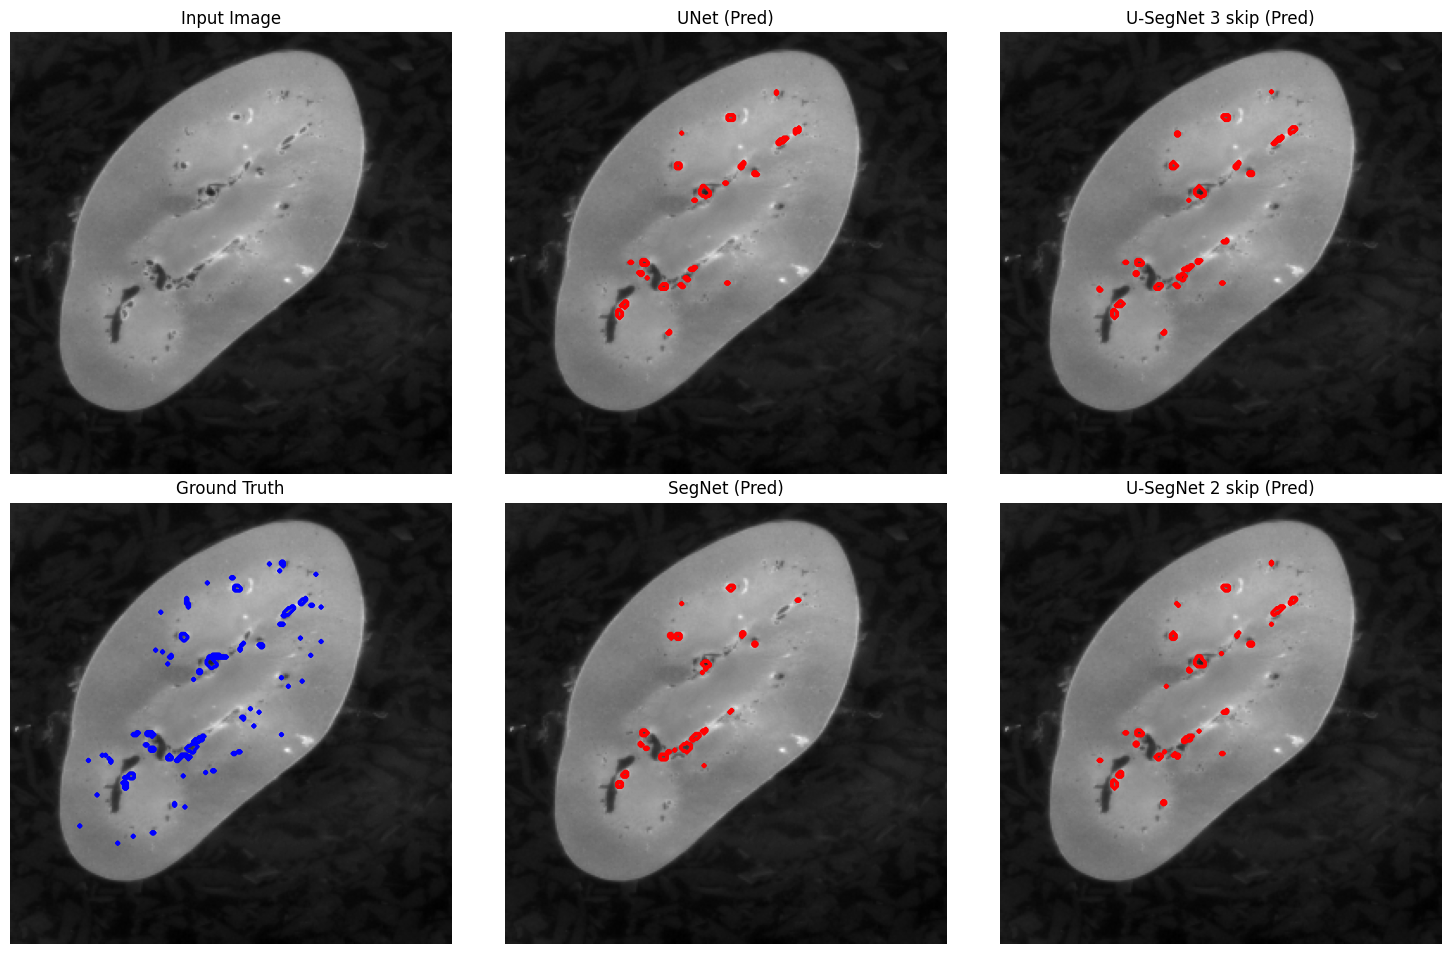

Saved the plot as: /kaggle/working/kidney_predictions_1.png


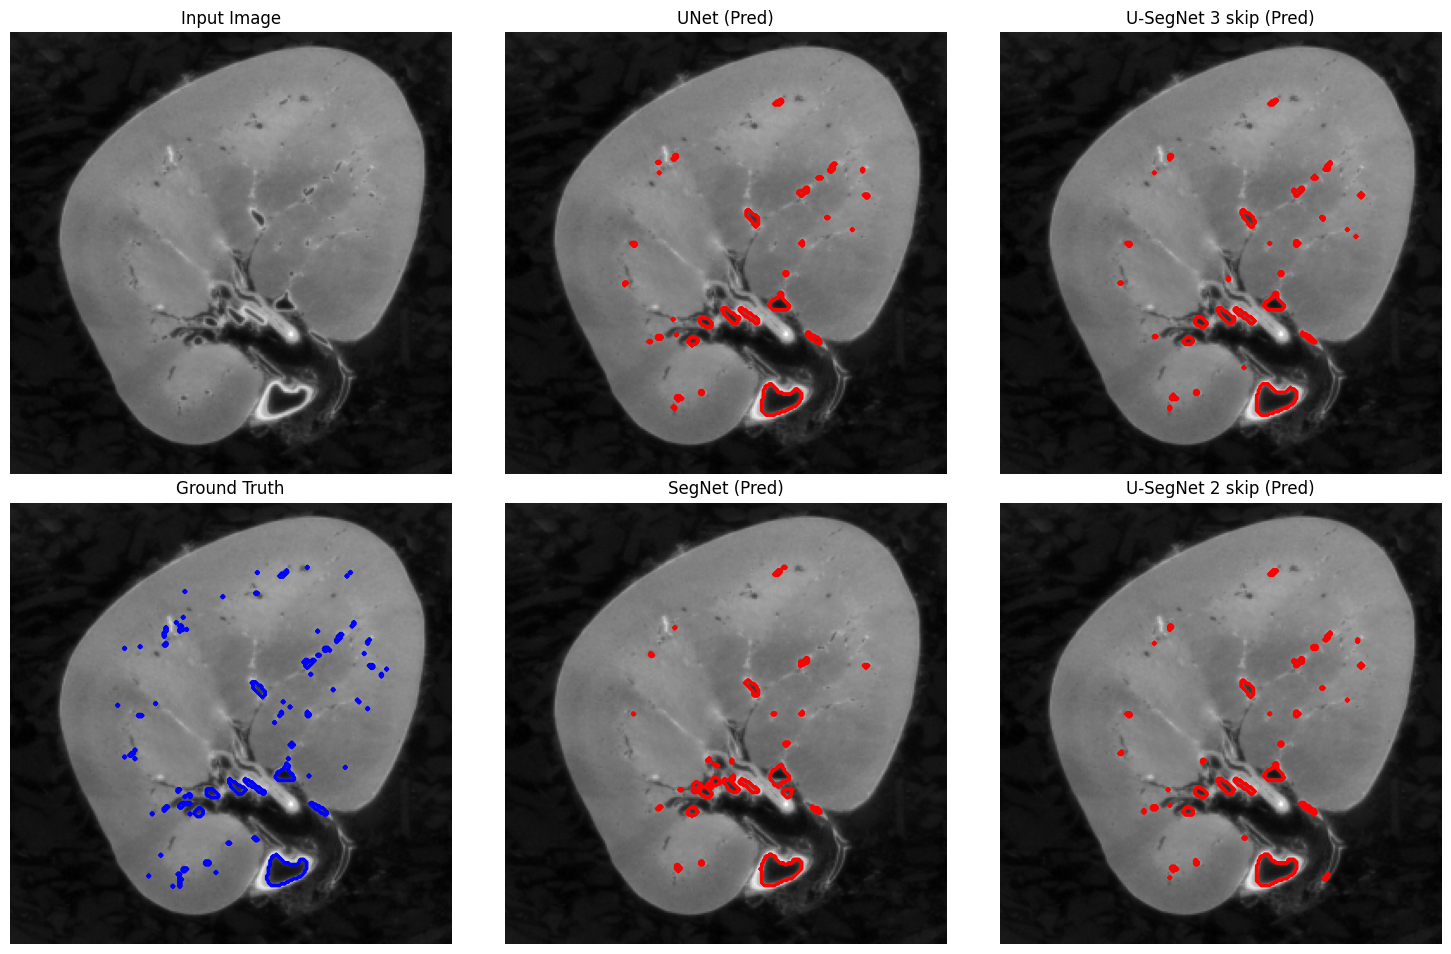

Saved the plot as: /kaggle/working/kidney_predictions_2.png


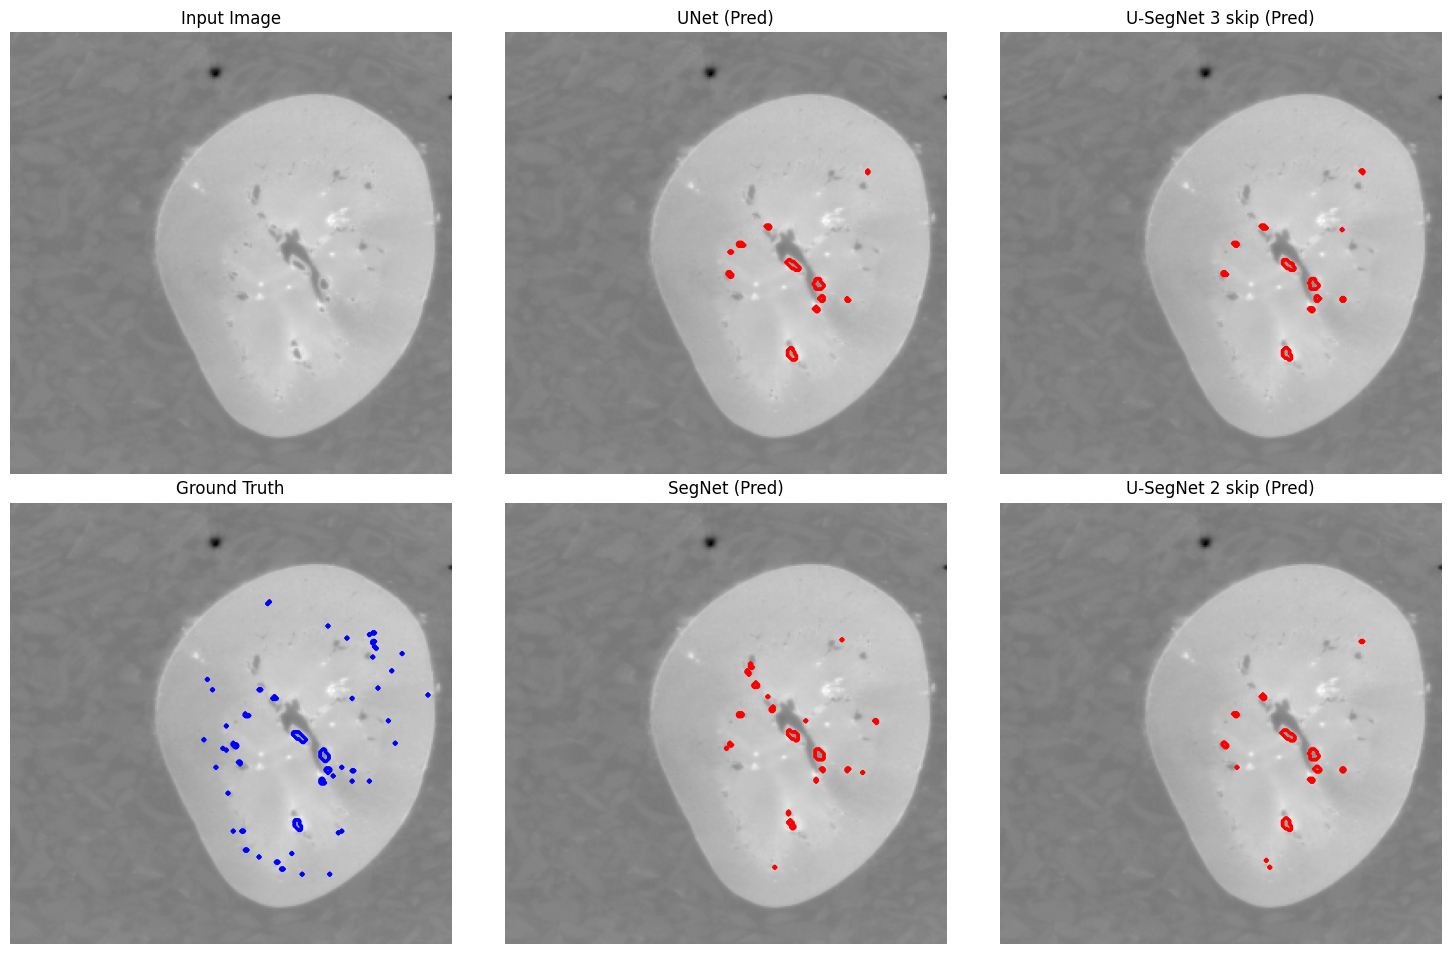

Saved the plot as: /kaggle/working/kidney_predictions_3.png


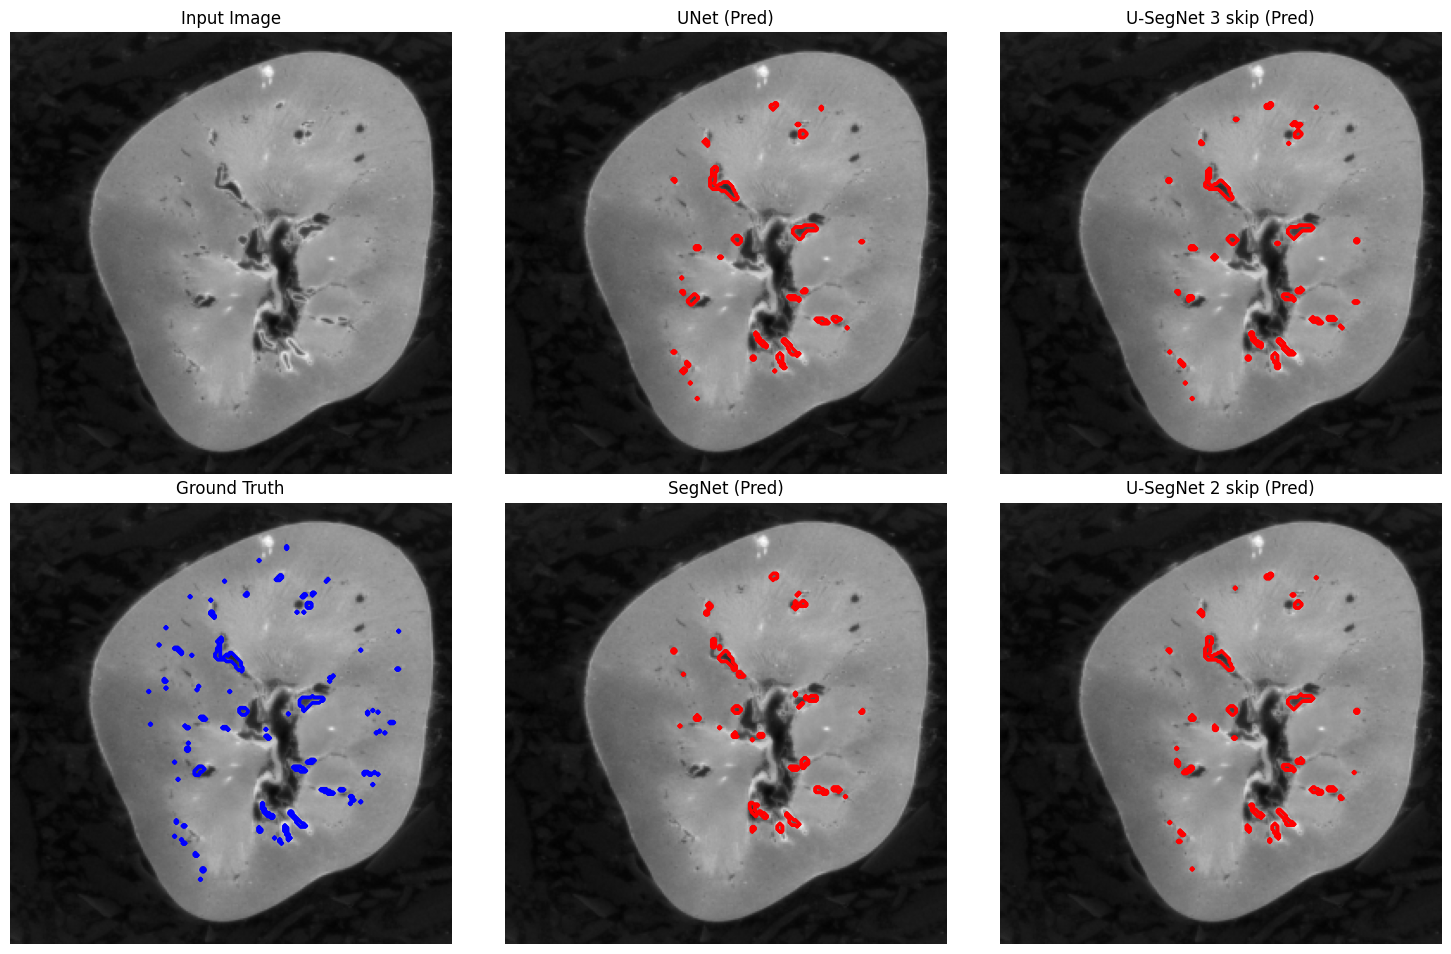

Saved the plot as: /kaggle/working/kidney_predictions_4.png


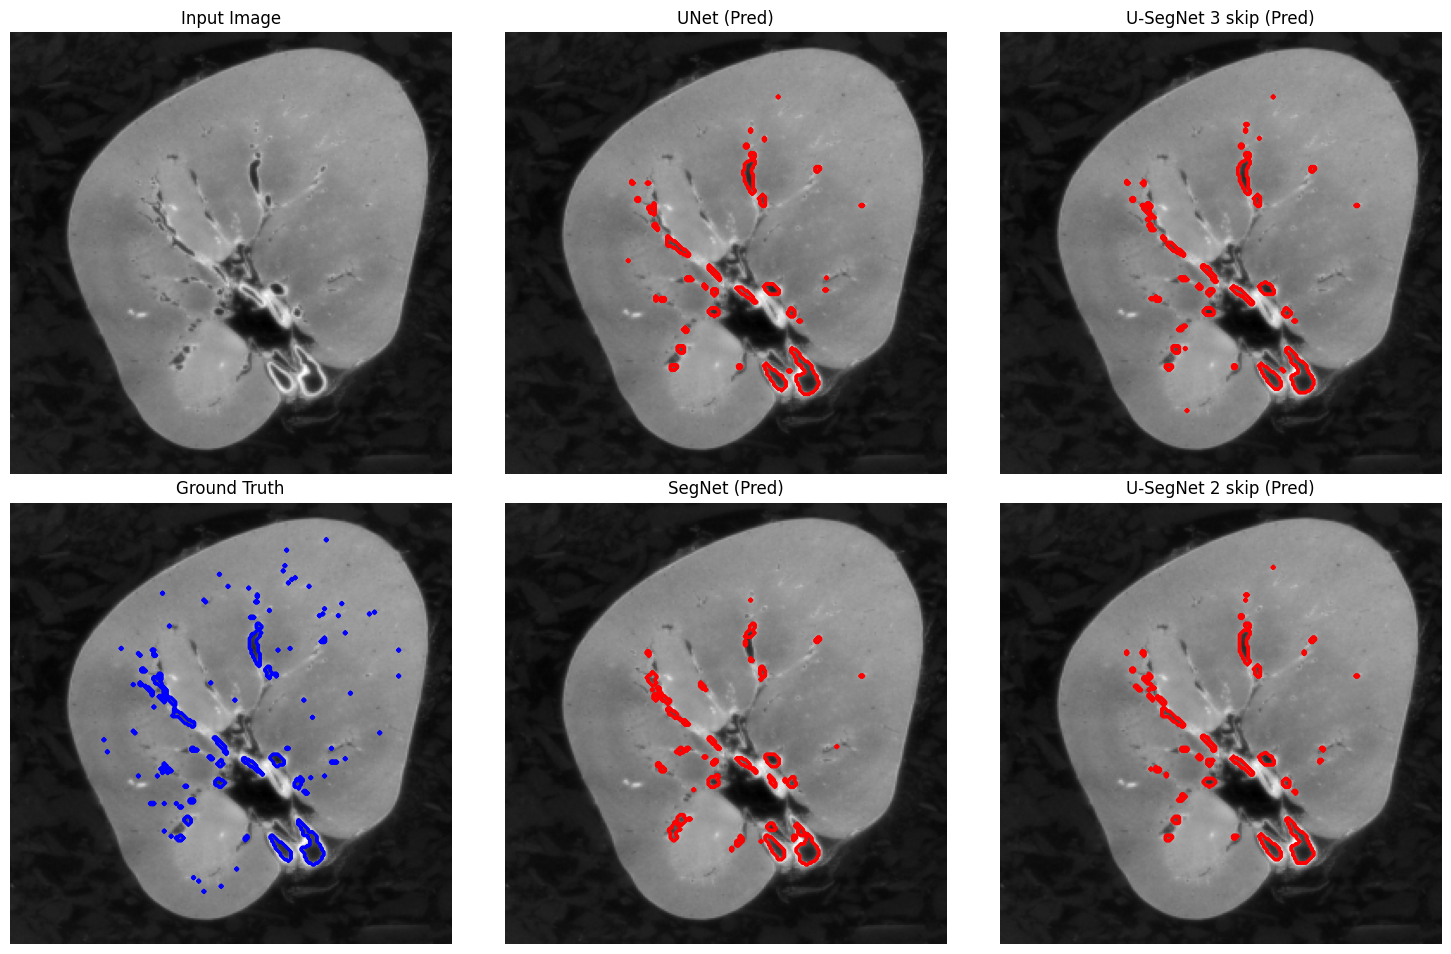

In [16]:
## Assume you already saved all trained models weights in /kaggle/input/retinausegnet/pytorch/default/1/

models = {
    'unet': UNet(1, 1),
    # 'residual_unet': ResidualUNet(1, 1),
    'segnet': SegNet(1, 1, 64),
    'usegnet_3skip': SegUNet_3skip(1, 1),
    'usegnet_2skip': SegUNet_2skip(1,1),
    # 'usegnet_1skip': SegUNet_1skip(1,1),
    'resusegnet': ResidualUSegNet(1,1)
}
visualize_segmentation_on_two_rows(models, val_loader, device=device, num_samples=5) # display only 4 models


models = {
    'unet': UNet(1, 1),
    # 'residual_unet': ResidualUNet(1, 1),
    'segnet': SegNet(1, 1, 64),
    'usegnet_3skip': SegUNet_3skip(1, 1),
    'usegnet_2skip': SegUNet_2skip(1,1),
    # 'usegnet_1skip': SegUNet_1skip(1,1),
    'resusegnet': ResidualUSegNet(1,1)
}

# build_metrics_table_and_visualize(models, val_loader, device=device, num_samples=3)